# IR Volatility Products

This notebook demonstrates *desk readiness* `IR Vol/Vanilla Vol + Exotics` integration. It deliberately goes beyond basic `Black + Greeks` by including:
- **Multi-curve plumbing** (discounting vs forwarding) and clean PV decomposition
- **Caps/floors as caplet strips** with a caplet ladder (how desks manage risk)
- **Swaptions** with **multi-curve key-rate DV01** (discount vs forwarding contributions)
- **Surface-node vega** with **bilinear interpolation** and **weight-based vega attribution** (dense vega map)
- A minimal **hedging workflow** (portfolio risk → hedge instrument → residual)
- An **exotics bridge**: toy **Bermudan swaption** via backward induction on a short-rate tree (mechanics + diagnostics)
- **Controls**: bump-size stability and unit conventions (avoid misleading outputs)
- **Awareness of VaR/ES constraints** (lightweight proxy, not a production engine)  
   How DV01/vega factors can be mapped into a **parametric VaR/ES proxy** under explicit assumptions—useful as a monitoring/communication layer

## Unit conventions
- Rates and vols are in **decimals** (e.g., 5% = 0.05)
- Times are in **years**
- DV01 is PV change per **1 bp** bump
- Vega is reported as:
  - **\$1.0 vol** (per 100% vol) and the desk-friendly
  - **\$1bp vol** (multiply by $10^{-4}$)

---
> **Note**: 
This notebook intentionally omits calendars/day-count, exact instrument bootstraps, and production smile/sticky conventions, but the *workflow and risk mapping* are faithful to desk practice.

## `client flow in IR vol`

In this notebook, **client flow** means the desk is continuously **intermediating client demand** in interest-rate volatility products (caps/floors, swaptions, and related structures) and managing the resulting inventory in real time. Typically, “client flow”  involves:
- **Two-way quoting at speed:** responding to RFQs with bid/offer premiums or implied vols across expiries/tenors/strikes as markets move.
- **Warehousing risk:** holding the risk you take when you trade (e.g., **DV01/delta**, **vega**, **gamma**, **theta**, **vanna**, **volga**) until it is hedged or offset by other flow.
- **Recycling risk with liquid hedges:** translating inventory into hedgeable coordinates (e.g., **key-rate DV01 buckets** and **expiry×tenor vega nodes**) and hedging with the most liquid instruments available.
- **P&L discipline and inventory-aware pricing:** quoting in a way that reflects current book exposures, hedge costs, market liquidity, limits, and capital—so the franchise can scale profitably.
---
> **Simple example**:
A client buys a **5Y cap** to protect against rising rates. The desk sells the cap, collects the premium, and now holds a **caplet-strip vega profile** (and some curve exposure). The desk then:
>1) decomposes the trade into a **caplet ladder** to see where PV and risk sit by maturity,  
>2) maps the vol exposure into a **vega bucket view** consistent with how it hedges (expiry/tenor nodes), and  
>3) hedges with liquid caps/swaptions to reduce the dominant exposures while monitoring residual risks (smile, basis, higher-order Greeks).

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from IPython.display import display

np.set_printoptions(precision=8, suppress=True)

## 1) Probability utilities and Black '76 pricer (rates options standard)

### Equations
Standard normal CDF/PDF: $N(\cdot)$ and $\varphi(\cdot)$.

Black '76 call/payer option on forward $F$ with strike $K$, vol $\sigma$, expiry $T$:
$$
d_1=\frac{\ln(F/K)+\frac12\sigma^2 T}{\sigma\sqrt{T}},\quad d_2=d_1-\sigma\sqrt{T}
$$
$$
\text{Black}(F,K,\sigma,T)=F N(d_1)-K N(d_2)\quad \text{(payer/call)}
$$

### Intuition
- In IR vol, swaptions/caplets are typically modeled as options on a forward (swap rate or forward rate).
- Black '76 is a quoting convention; the desk cares about **PV and hedgeable risk**.

### What the code does
- Implements $N(x)$ and $\varphi(x)$.
- Implements Black '76 option PV on a forward.

### Output
None (utilities only).

In [2]:
SQRT_2PI = math.sqrt(2.0 * math.pi)

def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

def norm_pdf(x: float) -> float:
    return math.exp(-0.5 * x * x) / SQRT_2PI

def black76_forward_option(F: float, K: float, vol: float, T: float, cp: int = 1) -> float:
    '''
    Black '76 option on forward F with strike K.
    cp = +1 payer/call, -1 receiver/put.
    Returns undiscounted option PV (i.e., on the forward measure).
    '''
    if T <= 0 or vol <= 0:
        return max(cp * (F - K), 0.0)
    if F <= 0 or K <= 0:
        raise ValueError("Black '76 requires F>0 and K>0 in this demo.")
    s = vol * math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * s * s) / s
    d2 = d1 - s
    return cp * (F * norm_cdf(cp * d1) - K * norm_cdf(cp * d2))

## 2) Multi-curve setup (discounting vs forwarding)

### Key equations
Discount factor under continuously-compounded zero rate $z(t)$:
$$
DF(0,t) = e^{-z(t)\,t}
$$

### Intuition
A desk must distinguish:
- **Discount curve** (OIS under CSA) used to PV cashflows $PV = \sum DF^{OIS}(0,t_i)\,CF_i$
- **Forwarding curve** used for projected rates / swap par rates (often different from OIS)

Even in simplified demos, separating the two is a strong signal of desk literacy.

### What the code does
We bootstrap piecewise (interpolated) zero rates from synthetic par swap rates. This is simplified (no calendars/day-count), but
- Builds a piecewise-interpolated zero curve object.
- Bootstraps (simplified) zero rates from synthetic par swap rates.
- Constructs both an OIS discount curve and a forwarding curve.

### Output
- A table of curve pillars and discount factors.
- A plot of the two zero curves, OIS discount curve vs forwarding curve.

In [3]:
@dataclass(frozen=True)
class PiecewiseZeroCurve:
    pillars: np.ndarray
    zero_rates: np.ndarray  # continuously-compounded

    def z(self, t: float) -> float:
        if t <= float(self.pillars[0]):
            return float(self.zero_rates[0])
        if t >= float(self.pillars[-1]):
            return float(self.zero_rates[-1])
        i = int(np.searchsorted(self.pillars, t) - 1)
        t0, t1 = float(self.pillars[i]), float(self.pillars[i+1])
        z0, z1 = float(self.zero_rates[i]), float(self.zero_rates[i+1])
        w = (t - t0) / (t1 - t0)
        return z0 + w * (z1 - z0)

    def df(self, t: float) -> float:
        return math.exp(-self.z(float(t)) * float(t))

def bootstrap_piecewise_zero_from_par_swaps(pillars, par_rates, pay_freq=2):
    '''
    Simplified bootstrap:
    Solve zero rates so that each maturity swap prices to par under:
      S = (1 - DF(T)) / A(T),
    with A computed from discount factors on the same curve.
    '''
    pillars = np.array(pillars, dtype=float)
    par_rates = np.array(par_rates, dtype=float)
    zr = np.zeros_like(pillars)

    def annuity(curve, end):
        alpha = 1.0/pay_freq
        pays = np.arange(alpha, end + 1e-12, alpha)
        return sum(curve.df(float(t)) * alpha for t in pays)

    for j, T in enumerate(pillars):
        zr[j] = par_rates[j]
        for _ in range(80):
            curve = PiecewiseZeroCurve(pillars[:j+1], zr[:j+1])
            A = annuity(curve, T)
            dfT = curve.df(T)
            model_S = (1.0 - dfT) / A
            err = model_S - par_rates[j]
            if abs(err) < 1e-12:
                break
            bump = 1e-5
            zr_b = zr.copy(); zr_b[j] += bump
            curve_b = PiecewiseZeroCurve(pillars[:j+1], zr_b[:j+1])
            A_b = annuity(curve_b, T)
            dfT_b = curve_b.df(T)
            model_S_b = (1.0 - dfT_b) / A_b
            derr = (model_S_b - model_S) / bump
            zr[j] -= err / max(1e-12, derr)

    return PiecewiseZeroCurve(pillars, zr)

pillars = [0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30]
ois_par  = [0.041, 0.0415, 0.042, 0.0422, 0.0425, 0.0427, 0.043, 0.0433, 0.0435, 0.0437]
swap_par = [0.043, 0.0435, 0.044, 0.0442, 0.0446, 0.045, 0.0455, 0.046, 0.0462, 0.0465]

disc_curve = bootstrap_piecewise_zero_from_par_swaps(pillars, ois_par, pay_freq=2)
fwd_curve  = bootstrap_piecewise_zero_from_par_swaps(pillars, swap_par, pay_freq=2)

curve_tbl = pd.DataFrame({
    "T": pillars,
    "z_ois": [disc_curve.z(t) for t in pillars],
    "z_fwd": [fwd_curve.z(t) for t in pillars],
    "DF_ois": [disc_curve.df(t) for t in pillars],
    "DF_fwd": [fwd_curve.df(t) for t in pillars],
})
curve_tbl.head()

,T,z_ois,z_fwd,DF_ois,DF_fwd
0,0.5,0.040585,0.042544,0.979912,0.978953
1,1.0,0.041080,0.043039,0.959752,0.957874
2,2.0,0.041579,0.043538,0.920205,0.916608
3,3.0,0.041779,0.043738,0.882199,0.877030
4,5.0,0.042087,0.044151,0.810231,0.801911


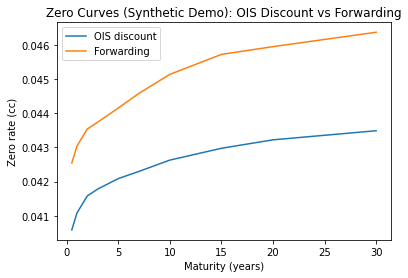

In [4]:
plt.figure()
plt.plot(curve_tbl["T"], curve_tbl["z_ois"])
plt.plot(curve_tbl["T"], curve_tbl["z_fwd"])
plt.title("Zero Curves (Synthetic Demo): OIS Discount vs Forwarding")
plt.xlabel("Maturity (years)")
plt.ylabel("Zero rate (cc)")
plt.legend(["OIS discount", "Forwarding"])
plt.show()

## 3) Caps as caplet strips (caplet ladder management)

### Equations
For accrual $\alpha$ and fixing $T_i$ paying $T_{i+1}$, a simple forward is:
$$
F_i = \frac{DF^{fwd}(0,T_i)}{DF^{fwd}(0,T_{i+1})}\frac{1}{\alpha} - \frac{1}{\alpha}
$$

Caplet PV under Black '76 (discount on OIS):
$$
PV_i = DF^{OIS}(0,T_{i+1})\cdot \alpha\cdot \text{Black}(F_i,K,\sigma_i,T_i)
$$
Cap PV is the strip sum: $PV_{cap}=\sum_i PV_i$.

### Parameter choice
To keep premiums in a “market-normal” range for a synthetic demo:
- Strike slightly OTM: $K=5.5\%$
- Moderate lognormal vol: $\sigma=28\%$ (flat)

### What the code does
- Builds a caplet schedule (quarterly).
- Computes forwards from the **forwarding curve** and discounts from the **OIS curve**.
- Prints a caplet ladder (forwards, DFs, caplet PVs).

### Output
- Cap PV (per $1$ notional)
- Ladder table for first caplets

In [5]:
def cap_pv(disc: PiecewiseZeroCurve, fwd: PiecewiseZeroCurve, end=5.0, freq=4, K=0.055, flat_vol=0.28):
    alpha = 1.0 / freq
    fix_times = np.arange(alpha, end + 1e-12, alpha)[:-1]
    pay_times = fix_times + alpha

    rows = []
    pv = 0.0
    for Ti, Tj in zip(fix_times, pay_times):
        DF_i = fwd.df(float(Ti))
        DF_j = fwd.df(float(Tj))
        F = (DF_i / DF_j - 1.0) / alpha

        caplet_undisc = alpha * black76_forward_option(F, K, flat_vol, float(Ti), cp=1)
        caplet = disc.df(float(Tj)) * caplet_undisc

        pv += caplet
        rows.append({"fix": float(Ti), "pay": float(Tj), "F": float(F), "DF_ois_pay": disc.df(float(Tj)), "caplet_PV": float(caplet)})
    return pv, pd.DataFrame(rows)

capPV, caplet_tbl = cap_pv(disc_curve, fwd_curve, end=5.0, freq=4, K=0.055, flat_vol=0.28)
capPV, caplet_tbl.head()

(0.017427432652335928,
     fix   pay         F  DF_ois_pay  caplet_PV
 0  0.25  0.50  0.042771    0.979912   0.000024
 1  0.50  0.75  0.043521    0.969840   0.000136
 2  0.75  1.00  0.044022    0.959752   0.000277
 3  1.00  1.25  0.043902    0.949798   0.000387
 4  1.25  1.50  0.044154    0.939888   0.000513)

## 4) Swaptions: PV decomposition and multi-curve key-rate DV01

### Decomposition
Fixed-leg annuity (OIS discounting):
$$
A^{OIS}=\sum_k \alpha_k DF^{OIS}(0,t_k)
$$
Par swap rate (forwarding curve):
$$
S=\frac{DF^{fwd}(0,T_s)-DF^{fwd}(0,T_e)}{A^{fwd}}
$$
European swaption PV (Black '76):
$$
PV = DF^{OIS}(0,T_{exp})\cdot A^{OIS}\cdot \text{Black}(S,K,\sigma,T_{exp})
$$

### Multi-curve DV01
In a multi-curve world, “delta” decomposes into:
- **Discounting DV01**: sensitivity to the OIS curve (PV scaling)
- **Forwarding DV01**: sensitivity to the forwarding curve (drives $S$ and is usually more hedge-relevant)

**Units:** DV01 is PV change per **1 bp** bump to the specified curve node.

### Output
- Swaption PV and $S$
- A DV01 table with `disc_DV01`, `fwd_DV01`, and `total_DV01`

In [6]:
def fixed_leg_annuity(curve: PiecewiseZeroCurve, start: float, end: float, pay_freq=2):
    alpha = 1.0/pay_freq
    pays = np.arange(start + alpha, end + 1e-12, alpha)
    return sum(curve.df(float(t)) * alpha for t in pays), pays

def par_swap_rate_from_curve(curve: PiecewiseZeroCurve, start: float, end: float, pay_freq=2):
    A, pays = fixed_leg_annuity(curve, start, end, pay_freq)
    return (curve.df(start) - curve.df(end)) / A, A, pays

def swaption_pv_black(disc: PiecewiseZeroCurve, fwd: PiecewiseZeroCurve,
                      expiry: float, start: float, end: float, K: float, vol: float,
                      cp: int = 1, pay_freq=2):
    S, _, _ = par_swap_rate_from_curve(fwd, start, end, pay_freq)
    A_ois, _ = fixed_leg_annuity(disc, start, end, pay_freq)
    df_exp = disc.df(expiry)
    return df_exp * A_ois * black76_forward_option(S, K, vol, expiry, cp=cp), S, A_ois

def bump_curve_node(curve: PiecewiseZeroCurve, idx: int, bump_bp: float):
    zr = curve.zero_rates.copy()
    zr[idx] += bump_bp / 10000.0
    return PiecewiseZeroCurve(curve.pillars.copy(), zr)

def key_rate_dv01_swaption_multicurve(disc, fwd, expiry, start, end, K, vol, cp=1, bump_bp=1.0):
    base, _, _ = swaption_pv_black(disc, fwd, expiry, start, end, K, vol, cp=cp)

    disc_rows = []
    for j in range(len(disc.pillars)):
        disc_b = bump_curve_node(disc, j, bump_bp)
        pv_b, _, _ = swaption_pv_black(disc_b, fwd, expiry, start, end, K, vol, cp=cp)
        disc_rows.append({"pillar_T": float(disc.pillars[j]), "disc_DV01": pv_b - base})

    fwd_rows = []
    for j in range(len(fwd.pillars)):
        fwd_b = bump_curve_node(fwd, j, bump_bp)
        pv_b, _, _ = swaption_pv_black(disc, fwd_b, expiry, start, end, K, vol, cp=cp)
        fwd_rows.append({"pillar_T": float(fwd.pillars[j]), "fwd_DV01": pv_b - base})

    out = pd.DataFrame(disc_rows).set_index("pillar_T").join(pd.DataFrame(fwd_rows).set_index("pillar_T"), how="outer").fillna(0.0)
    out["total_DV01"] = out["disc_DV01"] + out["fwd_DV01"]
    return out.reset_index(), base

# Example: 1Yx5Y ATM payer
expiry = 1.0
start  = 1.0
end    = 6.0
K_atm = par_swap_rate_from_curve(fwd_curve, start, end, 2)[0]

pv0, S0, A0 = swaption_pv_black(disc_curve, fwd_curve, expiry, start, end, K_atm, vol=0.25, cp=1)
pv0, S0, A0

(0.018428517325080947, 0.04509848718798623, 4.280052827605791)

In [7]:
# Single-trade DV01 demo (unit notional) — for intuition only
krdv01_demo, _ = key_rate_dv01_swaption_multicurve(
    disc_curve, fwd_curve, expiry, start, end, K_atm, vol=0.25, cp=1
)
krdv01_demo.head()

,pillar_T,disc_DV01,fwd_DV01,total_DV01
0,0.5,0.000000e+00,0.000000,0.000000
1,1.0,-1.994496e-06,-0.000050,-0.000052
2,2.0,-7.903828e-07,0.000004,0.000004
3,3.0,-1.864698e-06,0.000010,0.000008
4,5.0,-3.205517e-06,0.000140,0.000137


## 5) Surface-node vega: dense vega map via bilinear interpolation and weights

### Bilinear interpolation
Let $e_0 \le e \le e_1$ and $t_0 \le t \le t_1$. Define
$$w_e=\frac{e-e_0}{e_1-e_0},\quad w_t=\frac{t-t_0}{t_1-t_0}$$
Then
$$\sigma(e,t) = (1-w_e)(1-w_t)\sigma_{00} + (1-w_e)w_t\sigma_{01} + w_e(1-w_t)\sigma_{10} + w_e w_t\sigma_{11}$$

### Vega attribution
Trade vega $\nu=\frac{\partial P}{\partial \sigma}$ distributes to nodes by weights:
$$\text{VegaNode}_{ij} \approx \nu \cdot w_{ij}$$

### What the code does
- Builds a synthetic ATM surface on an expiry×tenor grid.
- Prices trades off-grid using bilinear interpolation.
- Computes each trade’s vega to its implied vol and distributes it to the 4 surrounding nodes.
- Reports a **dense** vega map and checks that node vegas sum to portfolio vega.

### Output
A dense pivot of vega per **1bp vol** by node.

In [8]:
expiries = np.array([0.5, 1.0, 2.0, 5.0], dtype=float)
tenors   = np.array([2.0, 5.0, 10.0], dtype=float)

atm_vol = pd.DataFrame(index=expiries, columns=tenors, data=[
    [0.29, 0.26, 0.24],
    [0.27, 0.25, 0.235],
    [0.24, 0.23, 0.22],
    [0.20, 0.195, 0.19],
])
atm_vol.index.name = "expiry"
atm_vol.columns.name = "tenor"
atm_vol

tenor,2.0,5.0,10.0
expiry,,,
0.5,0.29,0.260,0.240
1.0,0.27,0.250,0.235
2.0,0.24,0.230,0.220
5.0,0.20,0.195,0.190


In [9]:
def bilinear_vol_and_weights(surface: pd.DataFrame, e: float, t: float):
    e_grid = np.array(surface.index, dtype=float)
    t_grid = np.array(surface.columns, dtype=float)

    e = float(np.clip(e, e_grid.min(), e_grid.max()))
    t = float(np.clip(t, t_grid.min(), t_grid.max()))

    i1 = int(np.searchsorted(e_grid, e))
    if i1 == 0:
        e0 = e1 = e_grid[0]
    elif i1 >= len(e_grid):
        e0 = e1 = e_grid[-1]
    else:
        e0, e1 = e_grid[i1-1], e_grid[i1]

    j1 = int(np.searchsorted(t_grid, t))
    if j1 == 0:
        t0 = t1 = t_grid[0]
    elif j1 >= len(t_grid):
        t0 = t1 = t_grid[-1]
    else:
        t0, t1 = t_grid[j1-1], t_grid[j1]

    we = 0.0 if e1 == e0 else (e - e0) / (e1 - e0)
    wt = 0.0 if t1 == t0 else (t - t0) / (t1 - t0)

    s00 = float(surface.loc[e0, t0])
    s01 = float(surface.loc[e0, t1])
    s10 = float(surface.loc[e1, t0])
    s11 = float(surface.loc[e1, t1])

    w00 = (1-we) * (1-wt)
    w01 = (1-we) * wt
    w10 = we * (1-wt)
    w11 = we * wt

    vol = w00*s00 + w01*s01 + w10*s10 + w11*s11

    weights = [((float(e0), float(t0)), float(w00)),
               ((float(e0), float(t1)), float(w01)),
               ((float(e1), float(t0)), float(w10)),
               ((float(e1), float(t1)), float(w11))]

    agg = {}
    for node, w in weights:
        agg[node] = agg.get(node, 0.0) + w
    weights = [(node, w) for node, w in agg.items() if abs(w) > 1e-14]
    s = sum(w for _, w in weights)
    weights = [(node, w/s) for node, w in weights] if s != 0 else weights

    return vol, weights

_vol_test, _w_test = bilinear_vol_and_weights(atm_vol, e=1.3, t=7.0)
_vol_test, _w_test

(0.2386,
 [((1.0, 5.0), 0.42),
  ((1.0, 10.0), 0.27999999999999997),
  ((2.0, 5.0), 0.18000000000000002),
  ((2.0, 10.0), 0.12000000000000002)])

In [10]:
@dataclass
class SwaptionTrade:
    expiry: float
    tenor: float
    cp: int
    notional: float
    mny_bp: float = 0.0

def swaption_pv_from_surface_interp(tr: SwaptionTrade, disc, fwd, surface: pd.DataFrame, pay_freq=2):
    start = tr.expiry
    end = tr.expiry + tr.tenor
    S, _, _ = par_swap_rate_from_curve(fwd, start, end, pay_freq)
    K = max(1e-6, S + tr.mny_bp/10000.0)
    vol, wts = bilinear_vol_and_weights(surface, tr.expiry, tr.tenor)
    pv, _, _ = swaption_pv_black(disc, fwd, tr.expiry, start, end, K, vol, cp=tr.cp, pay_freq=pay_freq)
    return tr.notional * pv, vol, wts

def swaption_trade_vega(tr: SwaptionTrade, disc, fwd, surface: pd.DataFrame, bump_vol_bp=1.0, pay_freq=2):
    bump = bump_vol_bp / 10000.0
    pv0, vol0, wts = swaption_pv_from_surface_interp(tr, disc, fwd, surface, pay_freq=pay_freq)
    start = tr.expiry
    end = tr.expiry + tr.tenor
    S, _, _ = par_swap_rate_from_curve(fwd, start, end, pay_freq)
    K = max(1e-6, S + tr.mny_bp/10000.0)

    pv_up, _, _ = swaption_pv_black(disc, fwd, tr.expiry, start, end, K, vol0 + bump, cp=tr.cp, pay_freq=pay_freq)
    pv_dn, _, _ = swaption_pv_black(disc, fwd, tr.expiry, start, end, K, vol0 - bump, cp=tr.cp, pay_freq=pay_freq)
    pv_up *= tr.notional
    pv_dn *= tr.notional
    vega = (pv_up - pv_dn) / (2*bump)
    return vega, vol0, wts

def portfolio_node_vega(portfolio, disc, fwd, surface: pd.DataFrame, bump_vol_bp=1.0):
    nodes = [(float(e), float(t)) for e in surface.index for t in surface.columns]
    node_vega = {node: 0.0 for node in nodes}
    port_vega = 0.0

    for tr in portfolio:
        vega_tr, _, wts = swaption_trade_vega(tr, disc, fwd, surface, bump_vol_bp=bump_vol_bp)
        port_vega += vega_tr
        for node, w in wts:
            node_vega[node] += vega_tr * w

    out = pd.DataFrame([{"expiry": n[0], "tenor": n[1], "vega_node": v} for n, v in node_vega.items()])
    out["vega_per_1bp_vol"] = out["vega_node"] * 1e-4
    return out, port_vega

def portfolio_key_rate_dv01(portfolio, disc, fwd, surface: pd.DataFrame, bump_bp: float = 1.0, pay_freq: int = 2):
    """
    Aggregates key-rate DV01 across the swaption portfolio using the SAME
    strike construction and vol interpolation used for PV/vega.
    
    Output units: $ per 1bp bump at each curve pillar (pillar_T).
    """
    agg = None

    for tr in portfolio:
        start = tr.expiry
        end   = tr.expiry + tr.tenor

        # underlying par swap rate for strike construction
        S, _, _ = par_swap_rate_from_curve(fwd, start, end, pay_freq)
        K = max(1e-6, S + tr.mny_bp / 10000.0)

        # vol from the same bilinear interpolation used in pricing/vega sections
        vol, _ = bilinear_vol_and_weights(surface, tr.expiry, tr.tenor)

        tbl_unit, _ = key_rate_dv01_swaption_multicurve(
            disc, fwd, tr.expiry, start, end, K, vol, cp=tr.cp, bump_bp=bump_bp
        )

        # Scale DV01 by trade notional to get currency DV01
        for col in ["disc_DV01", "fwd_DV01", "total_DV01"]:
            tbl_unit[col] *= tr.notional

        x = tbl_unit.set_index("pillar_T")[["disc_DV01", "fwd_DV01", "total_DV01"]]
        agg = x if agg is None else agg.add(x, fill_value=0.0)

    return agg.reset_index()


portfolio = [
    SwaptionTrade(1.0, 5.0,  cp=1,  notional=100e6, mny_bp=0.0),
    SwaptionTrade(2.0, 10.0, cp=-1, notional=50e6,  mny_bp=-25.0),
    SwaptionTrade(1.3, 7.0,  cp=1,  notional=60e6,  mny_bp=25.0),
]

vega_nodes, port_vega = portfolio_node_vega(portfolio, disc_curve, fwd_curve, atm_vol, bump_vol_bp=1.0)
dense_map = vega_nodes.pivot_table(index="expiry", columns="tenor", values="vega_per_1bp_vol")

dense_map

tenor,2.0,5.0,10.0
expiry,,,
0.5,0.0,0.000000,0.000000
1.0,0.0,1013.947299,187.091925
2.0,0.0,120.273381,919.452178
5.0,0.0,0.000000,0.000000


In [11]:
sum_node_vega = vega_nodes["vega_node"].sum()
pd.DataFrame({
    "portfolio_vega_$per_1.0vol": [port_vega],
    "sum_node_vega_$per_1.0vol": [sum_node_vega],
    "difference": [sum_node_vega - port_vega],
    "portfolio_vega_$per_1bpvol": [port_vega * 1e-4],
})

,portfolio_vega_$per_1.0vol,sum_node_vega_$per_1.0vol,difference,portfolio_vega_$per_1bpvol
0,2.240765e+07,2.240765e+07,0.0,2240.764783


In [12]:
# Portfolio key-rate DV01 — this is what risk/VaR/limits should use
krdv01_tbl_portfolio = portfolio_key_rate_dv01(portfolio, disc_curve, fwd_curve, atm_vol, bump_bp=1.0, pay_freq=2)
krdv01_tbl_portfolio.head()

,pillar_T,disc_DV01,fwd_DV01,total_DV01
0,0.5,0.000000,0.000000,0.000000
1,1.0,-318.138940,-7335.093053,-7653.231994
2,2.0,-475.539994,2755.172020,2279.632026
3,3.0,-370.208964,1224.846164,854.637199
4,5.0,-662.647218,14373.835967,13711.188749


In [13]:
pd.DataFrame([{
    "sum_rate_DV01_$_per_bp": krdv01_tbl_portfolio["total_DV01"].sum(),
    "sum_abs_rate_DV01_$_per_bp": krdv01_tbl_portfolio["total_DV01"].abs().sum()
}])

,sum_rate_DV01_$_per_bp,sum_abs_rate_DV01_$_per_bp
0,23087.275109,53150.152466


## 6) Minimal hedging workflow: reduce dominant vega node exposure

### Intuition
A desk-level workflow is:
1. Compute vega map (expiry×tenor).
2. Identify dominant node(s).
3. Choose hedge instruments and size them to reduce exposures.
4. Monitor residual risks (smile, basis, higher-order Greeks).

### What the code does
- Finds the largest absolute vega node (per 1bp vol).
- Uses a single hedge instrument at that node (toy) and sizes it to offset the exposure.
- Reports vega map before and after.

### Output
Before/after vega map (per 1bp vol).

In [14]:
dom_row = vega_nodes.iloc[int(vega_nodes["vega_per_1bp_vol"].abs().argmax())]
target = (float(dom_row["expiry"]), float(dom_row["tenor"]))
dom_row, target

(expiry              1.000000e+00
 tenor               5.000000e+00
 vega_node           1.013947e+07
 vega_per_1bp_vol    1.013947e+03
 Name: 4, dtype: float64,
 (1.0, 5.0))

In [15]:
hedge_unit = [SwaptionTrade(target[0], target[1], cp=1, notional=1.0, mny_bp=0.0)]
hedge_nodes, _ = portfolio_node_vega(hedge_unit, disc_curve, fwd_curve, atm_vol)

hedge_node_vec = hedge_nodes.set_index(["expiry","tenor"])["vega_node"]
port_node_vec  = vega_nodes.set_index(["expiry","tenor"])["vega_node"]

scale = float(port_node_vec.loc[target] / max(1e-12, hedge_node_vec.loc[target]))
hedge = [SwaptionTrade(target[0], target[1], cp=1, notional=-scale, mny_bp=0.0)]

portfolio_hedged = portfolio + hedge
vega_nodes_after, _ = portfolio_node_vega(portfolio_hedged, disc_curve, fwd_curve, atm_vol)

before = vega_nodes.pivot_table(index="expiry", columns="tenor", values="vega_per_1bp_vol")
after  = vega_nodes_after.pivot_table(index="expiry", columns="tenor", values="vega_per_1bp_vol")
before, after

(tenor   2.0          5.0         10.0
 expiry                               
 0.5      0.0     0.000000    0.000000
 1.0      0.0  1013.947299  187.091925
 2.0      0.0   120.273381  919.452178
 5.0      0.0     0.000000    0.000000,
 tenor   2.0           5.0         10.0
 expiry                                
 0.5      0.0  0.000000e+00    0.000000
 1.0      0.0 -1.281500e-10  187.091925
 2.0      0.0  1.202734e+02  919.452178
 5.0      0.0  0.000000e+00    0.000000)

## 7) Exotics bridge: Bermudan swaption via backward induction on a toy short-rate tree

### Core recursion
At an exercise time $t$:
$$
V(t)=\max\left(\text{ExerciseValue}(t),\; \mathbb{E}[DF(t,t+\Delta t)\,V(t+\Delta t)]\right)
$$

### What the code does
- Builds a recombining short-rate tree (toy).
- Values a Bermudan payer swaption via backward induction.
- Produces a diagnostics table at the first exercise date showing exercise vs continuation.

`This Bermudan is a toy early-exercise demonstration: continuation comes from a recombining short-rate tree; exercise value uses a local flat-curve approximation at each node. The goal is to illustrate recursion/diagnostics, not calibration.`

### Output
- Bermudan PV (toy)
- Diagnostics table

In [16]:
def hw_tree(a=0.05, sigma=0.01, dt=0.5, n_steps=20, r0=0.04):
    dr = sigma * math.sqrt(dt)
    tree = [{0: r0}]
    for i in range(1, n_steps + 1):
        level = {}
        for j in range(-i, i + 1):
            r = r0 + (j * dr) * math.exp(-a * i * dt)
            level[j] = r
        tree.append(level)
    return tree, dt

def bermudan_swaption_hw_tree(notional, K, exercise_times, swap_end, pay_freq=2,
                             a=0.05, sigma=0.01, r0=0.04):
    dt = 1.0 / pay_freq
    n_steps = int(round(swap_end / dt))
    tree, dt = hw_tree(a=a, sigma=sigma, dt=dt, n_steps=n_steps, r0=r0)

    alpha = 1.0 / pay_freq
    pay_times = np.arange(alpha, swap_end + 1e-12, alpha)
    ex_steps = set(int(round(t / dt)) for t in exercise_times)

    V = {j: 0.0 for j in tree[-1].keys()}
    diag_step = min(ex_steps) if len(ex_steps) else None
    diag_rows = []
    
    for i in reversed(range(n_steps)):
        level = tree[i]
        next_level = tree[i + 1]
        V_new = {}

        # Safety: ensure child indices are valid in the next level
        min_j = min(next_level.keys())
        max_j = max(next_level.keys())

        for j, r in level.items():
            # Binomial children (recombining tree): j -> j-1, j+1
            j_dn = min(max(j - 1, min_j), max_j)
            j_up = min(max(j + 1, min_j), max_j)

            cont = 0.5 * V.get(j_dn, 0.0) + 0.5 * V.get(j_up, 0.0)
            cont_pv = math.exp(-r * dt) * cont

            if i in ex_steps:
                # Toy exercise value computed from node short rate r (local flat curve assumption)
                def df_rel(t): return math.exp(-r * t)

                A = sum(alpha * df_rel(t - i * dt) for t in pay_times if t >= i * dt + alpha)
                df_end = df_rel(swap_end - i * dt)
                S = (1.0 - df_end) / A if A > 0 else 0.0

                exercise_val = notional * A * max(S - K, 0.0)
                V_new[j] = max(exercise_val, cont_pv)

                if diag_step is not None and i == diag_step:
                    diag_rows.append({
                        "node_j": j, "r_node": r, "swap_rate_S": S, "annuity_A": A,
                        "exercise_value": exercise_val, "continuation": cont_pv,
                        "decision": "EXERCISE" if exercise_val >= cont_pv else "CONTINUE"
                    })
            else:
                V_new[j] = cont_pv

        V = V_new

    diag = pd.DataFrame(diag_rows).sort_values("node_j") if diag_rows else pd.DataFrame()
    return V[0], diag

berm_pv, berm_diag = bermudan_swaption_hw_tree(
    notional=100e6,
    K=0.045,
    exercise_times=[1,2,3,4,5],
    swap_end=10,
    a=0.05,
    sigma=0.01,
    r0=0.04
)
berm_pv

2763979.4278662205

In [17]:
berm_diag.head(15)

,node_j,r_node,swap_rate_S,annuity_A,exercise_value,continuation,decision
0,-2,0.026548,0.026725,7.952558,0.000000e+00,6.101267e+05,CONTINUE
1,-1,0.033274,0.033552,7.712916,0.000000e+00,1.141905e+06,CONTINUE
2,0,0.040000,0.040403,7.482763,0.000000e+00,2.225384e+06,CONTINUE
3,1,0.046726,0.047276,7.261673,1.652988e+06,3.913096e+06,CONTINUE
4,2,0.053452,0.054173,7.049243,6.466349e+06,6.138748e+06,EXERCISE


## 8) Controls: bump-size stability (numerical risk hygiene)

### Intuition
A differentiator is not just producing Greeks, but validating they are **stable** across bump sizes.

### What the code does
- Computes finite-difference Greeks for a representative Black option under multiple $dF$ values.
- Displays the estimates so instability is visible.

### Output
A table of Greek estimates vs bump size.

In [18]:
def fd_greeks(price_fn, F, vol, T, dF, dvol):
    P = price_fn(F, vol, T)
    Pu = price_fn(F+dF, vol, T); Pd = price_fn(F-dF, vol, T)
    delta = (Pu - Pd) / (2*dF)
    gamma = (Pu - 2*P + Pd) / (dF*dF)
    Vu = price_fn(F, vol+dvol, T); Vd = price_fn(F, vol-dvol, T)
    vega = (Vu - Vd) / (2*dvol)
    volga = (Vu - 2*P + Vd) / (dvol*dvol)
    return P, delta, gamma, vega, volga

def black_price(F, vol, T):
    return black76_forward_option(F, K=0.05, vol=vol, T=T, cp=1)

F = 0.05
vol = 0.25
T = 2.0
dvol = 1e-4
bumps = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4]

rows = []
for dF in bumps:
    P, d, g, v, vg = fd_greeks(black_price, F, vol, T, dF=dF, dvol=dvol)
    rows.append({"dF": dF, "price": P, "delta": d, "gamma": g, "vega": v, "volga": vg})

pd.DataFrame(rows)

,dF,price,delta,gamma,vega,volga
0,0.00001,0.007016,0.570158,22.217705,0.027772,-0.003472
1,0.00002,0.007016,0.570158,22.217704,0.027772,-0.003472
2,0.00005,0.007016,0.570158,22.217698,0.027772,-0.003472
3,0.00010,0.007016,0.570157,22.217674,0.027772,-0.003472
4,0.00020,0.007016,0.570154,22.217579,0.027772,-0.003472


## 9) Summary

`Client flow in IR vol requires fast, consistent quoting across caps/swaptions and coherent risk aggregation across curves and the vol surface, while the franchise benefits from tighter alignment between vanilla and exotics workflows.`

This notebook demonstrates how to: 

1. **Develop and implement strategies for business growth**
   - **Trading workflow / hedge & residual** sections: demonstrates how to translate risk into actionable hedges and communicate residuals—critical for scalable client flow.
   - **Summary** section: frames the process as a repeatable product/coverage workflow.

2. **Act as a counterparty for IR volatility products; provide timely price quotations**
   - **Caps** and **Swaptions** sections: show a clean quote path: **curves + surface → forwards/par rates → annuity → Black PV**.
   - **Caplet ladder**: mirrors how desks explain cap premium and where the risk lives along the strip.

3. **Manage risks (delta, vega, gamma, theta, vanna, volga; etc.)**
   - **Key-rate DV01**: expresses “delta” in hedgeable buckets and separates **discounting vs forwarding** contributions (multi-curve).
   - **Surface-node vega**: reports expiry×tenor risk in desk-like buckets (and, where implemented, uses interpolation weights to avoid sparse maps).
   - **Controls / bump checks**: demonstrates numerical hygiene for first/second-order risk (gamma/volga stability).

4. **Contribute to development of mathematical models for new/existing payoffs**
   - **Bermudan (exotics bridge)**: demonstrates backward induction (exercise vs continuation), diagnostics, and how exotics valuation differs structurally from European products.

5. **Facilitate integration of Vanilla Vol desk with Exotics desk**
   - **Vega map + Bermudan mechanics** sections: connect vanilla surface conventions/risk to early-exercise logic and diagnostics.
   - **Multi-curve DV01**: highlights the shared foundational inputs (curves) required for consistent cross-desk risk.

6. **Coordinate with Sales, Engineering, and Quants**
   - **Sales**: ladder/table and vega/DV01 outputs support fast explanation of premium and risk.
   - **Quants/Model Risk**: explicit assumptions + diagnostics + stability checks.
   - **Engineering**: modular components (curve object, pricers, risk functions) that can be lifted into libraries.

---

## Appendix: Lightweight VaR / ES proxy from Greeks 

### Why include this?
VaR/ES is not “back office”; desks manage to VaR/ES **limits** and use the metric as a monitoring layer.
However, production VaR/ES is typically computed on broader infrastructure (P&L vectors, scenarios, governance).
This appendix provides a **lightweight proxy** to demonstrate awareness and connect the Greeks in this notebook to a VaR/ES framework.

### Method (parametric normal approximation)
Approximate 1-day P&L using a linear factor model:
$$\Delta P \approx \sum_i w_i X_i$$
where:
- $w_i$ are exposures (e.g., DV01 bucket $\$/bp$ or node vega $\$/bp\;vol$),
- $X_i$ are 1-day shocks in **bp** (rates) or **vol bp** (vol).

Assume $X \sim \mathcal{N}(0,\Sigma)$:
$$\sigma_P = \sqrt{w^\top \Sigma w}$$

For confidence level $q$ (e.g., 99%), with normal quantile $z_q$:
$$\text{VaR}_q \approx z_q \, \sigma_P$$
Normal expected shortfall:
$$\text{ES}_q \approx \frac{\varphi(z_q)}{1-q}\,\sigma_P$$

### What the code does
- Builds a **factor vector** from the most material key-rate DV01 buckets and vega nodes already computed.
- Uses explicit, configurable assumptions for 1-day shock sizes and correlations to build $\Sigma$.
- Reports **VaR/ES proxy** and **factor contributions** (under the stated assumptions).

### Output
- 1-day VaR/ES proxy (currency units)
- Ranked factor contributions

>Note: Exposures are held fixed; only the assumed shock distribution changes.

In [19]:

def normal_z(q: float) -> float:
    # Acklam inverse-normal approximation 
    if not (0.0 < q < 1.0):
        raise ValueError("q must be in (0,1)")
    a = [-3.969683028665376e+01, 2.209460984245205e+02, -2.759285104469687e+02,
         1.383577518672690e+02, -3.066479806614716e+01, 2.506628277459239e+00]
    b = [-5.447609879822406e+01, 1.615858368580409e+02, -1.556989798598866e+02,
         6.680131188771972e+01, -1.328068155288572e+01]
    c = [-7.784894002430293e-03, -3.223964580411365e-01, -2.400758277161838e+00,
         -2.549732539343734e+00, 4.374664141464968e+00, 2.938163982698783e+00]
    d = [7.784695709041462e-03, 3.224671290700398e-01, 2.445134137142996e+00,
         3.754408661907416e+00]
    plow = 0.02425
    phigh = 1 - plow
    if q < plow:
        r = math.sqrt(-2.0 * math.log(q))
        num = (((((c[0]*r + c[1])*r + c[2])*r + c[3])*r + c[4])*r + c[5])
        den = ((((d[0]*r + d[1])*r + d[2])*r + d[3])*r + 1.0)
        return num / den
    if q > phigh:
        r = math.sqrt(-2.0 * math.log(1.0 - q))
        num = -(((((c[0]*r + c[1])*r + c[2])*r + c[3])*r + c[4])*r + c[5])
        den = ((((d[0]*r + d[1])*r + d[2])*r + d[3])*r + 1.0)
        return num / den
    r = q - 0.5
    s = r * r
    num = (((((a[0]*s + a[1])*s + a[2])*s + a[3])*s + a[4])*s + a[5]) * r
    den = (((((b[0]*s + b[1])*s + b[2])*s + b[3])*s + b[4])*s + 1.0)
    return num / den

def phi(z: float) -> float:
    return math.exp(-0.5*z*z) / math.sqrt(2.0*math.pi)

def build_factor_vector(krdv01_tbl: pd.DataFrame, vega_nodes: pd.DataFrame,
                        top_dv01: int = 5, top_vega: int = 6) -> pd.DataFrame:
    """
    Factors are derived from existing notebook outputs:
    - Rates: total_DV01 by key rate (units: $ per 1bp)
    - Vol: vega_node by surface node (units: $ per 1.0 vol); converted to $ per 1bp vol
    """
    dv = krdv01_tbl.copy()
    dv["abs"] = dv["total_DV01"].abs()
    dv = dv.sort_values("abs", ascending=False).head(top_dv01)
    dv_factors = [f"DV01(T={t:g})" for t in dv["pillar_T"].to_numpy(dtype=float)]
    dv_w = dv["total_DV01"].to_numpy(dtype=float)  # $ per bp

    vg = vega_nodes.copy()
    vg["vega_per_1bp_vol"] = vg["vega_node"] * 1e-4  # $/1.0 vol -> $/1bp vol
    vg["abs"] = vg["vega_per_1bp_vol"].abs()
    vg = vg.sort_values("abs", ascending=False).head(top_vega)
    vg_factors = [f"VEGA({row.expiry:g}x{row.tenor:g})" for row in vg.itertuples()]
    vg_w = vg["vega_per_1bp_vol"].to_numpy(dtype=float)  # $ per vol-bp

    factors = dv_factors + vg_factors
    w = np.concatenate([dv_w, vg_w])
    types = (["rate"] * len(dv_w)) + (["vol"] * len(vg_w))
    return pd.DataFrame({"factor": factors, "type": types, "exposure": w})

def simple_covariance(factors: pd.DataFrame,
                      sigma_rate_bp: float = 5.0,
                      sigma_vol_bp: float = 3.0,
                      rho_rate: float = 0.50,
                      rho_vol: float = 0.35,
                      rho_cross: float = 0.15) -> np.ndarray:
    """
    Covariance of factor shocks X (bp units).
    Correlations are constant within blocks and rho_cross across blocks.
    """
    n = len(factors)
    sig = np.where(factors["type"].to_numpy() == "rate", sigma_rate_bp, sigma_vol_bp).astype(float)

    Sigma = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if i == j:
                rho = 1.0
            else:
                ti, tj = factors.loc[i, "type"], factors.loc[j, "type"]
                if ti == "rate" and tj == "rate":
                    rho = rho_rate
                elif ti == "vol" and tj == "vol":
                    rho = rho_vol
                else:
                    rho = rho_cross
            Sigma[i, j] = rho * sig[i] * sig[j]
    return Sigma

def var_es_proxy(factors: pd.DataFrame, Sigma: np.ndarray, q: float = 0.99):
    w = factors["exposure"].to_numpy(dtype=float)
    sigma_P = float(np.sqrt(max(0.0, w @ Sigma @ w)))
    z = normal_z(q)
    VaR = z * sigma_P
    ES = (phi(z) / (1.0 - q)) * sigma_P

    Sw = Sigma @ w
    mcs = Sw / max(1e-12, sigma_P)  # marginal contribution to sigma_P
    contrib_VaR = z * (w * mcs)     # Euler allocation
    contrib_ES = (phi(z) / (1.0 - q)) * (w * mcs)

    contrib = factors.copy()
    contrib["VaR_contrib"] = contrib_VaR
    contrib["ES_contrib"] = contrib_ES

    summary = pd.DataFrame({
        "q": [q],
        "sigma_P": [sigma_P],
        "VaR_proxy": [VaR],
        "ES_proxy": [ES],
        "z_q": [z],
        "phi(z_q)": [phi(z)]
    })
    return summary, contrib.sort_values("VaR_contrib", key=lambda s: s.abs(), ascending=False)

In [20]:
# --- Use outputs already computed in the notebook ---
factors = build_factor_vector(krdv01_tbl_portfolio, vega_nodes, top_dv01=5, top_vega=6)

# Drop tiny exposures so the report doesn't show dead rows
factors = factors.loc[factors["exposure"].abs() > 1e-8].reset_index(drop=True)

# Sanity-check headline exposures (units: rate=$/bp, vol=$/vol-bp)
rate_exp = factors.loc[factors["type"] == "rate", "exposure"].sum()
vol_exp  = factors.loc[factors["type"] == "vol",  "exposure"].sum()
exposure_summary = pd.DataFrame([{
    "sum_rate_DV01_$_per_bp": rate_exp,
    "sum_vega_$_per_volbp": vol_exp
}])
exposure_summary


def run_var_es_scenario(factors: pd.DataFrame, q: float, *,
                        sigma_rate_bp: float,
                        sigma_vol_bp: float,
                        rho_rate: float,
                        rho_vol: float,
                        rho_cross: float):
    """
    Runs one VaR/ES proxy scenario and returns:
    - assumptions table
    - summary (sigma_P, VaR, ES)
    - signed factor contributions (Euler allocation)
    """
    Sigma = simple_covariance(
        factors,
        sigma_rate_bp=sigma_rate_bp,
        sigma_vol_bp=sigma_vol_bp,
        rho_rate=rho_rate,
        rho_vol=rho_vol,
        rho_cross=rho_cross
    )

    summary, contrib = var_es_proxy(factors, Sigma, q=q)

    assumptions = pd.DataFrame([{
        "q": q,
        "sigma_rate_bp": sigma_rate_bp,
        "sigma_vol_bp": sigma_vol_bp,
        "rho_rate": rho_rate,
        "rho_vol": rho_vol,
        "rho_cross": rho_cross,
        "note": "Contributions are signed (Euler allocation); negatives can occur under correlations."
    }])

    # Add a total row check (sum of contributions should be close to VaR/ES)
    contrib_check = pd.DataFrame([{
        "VaR_proxy": float(summary["VaR_proxy"].iloc[0]),
        "sum_VaR_contrib": float(contrib["VaR_contrib"].sum()),
        "VaR_diff": float(contrib["VaR_contrib"].sum() - summary["VaR_proxy"].iloc[0]),
        "ES_proxy": float(summary["ES_proxy"].iloc[0]),
        "sum_ES_contrib": float(contrib["ES_contrib"].sum()),
        "ES_diff": float(contrib["ES_contrib"].sum() - summary["ES_proxy"].iloc[0]),
    }])

    return assumptions, summary, contrib, contrib_check


# -----------------------
# Base vs Stress scenarios
# -----------------------
q = 0.99

scenarios = {
    "Base": dict(
        sigma_rate_bp=2.0,
        sigma_vol_bp=10.0,
        rho_rate=0.50,
        rho_vol=0.35,
        rho_cross=0.15
    ),
    "Stress": dict(
        sigma_rate_bp=5.0,
        sigma_vol_bp=20.0,
        rho_rate=0.65,
        rho_vol=0.50,
        rho_cross=0.25
    )
}

results = {}

for name, p in scenarios.items():
    assumptions, summary, contrib, contrib_check = run_var_es_scenario(
        factors, q,
        sigma_rate_bp=p["sigma_rate_bp"],
        sigma_vol_bp=p["sigma_vol_bp"],
        rho_rate=p["rho_rate"],
        rho_vol=p["rho_vol"],
        rho_cross=p["rho_cross"]
    )

    results[name] = dict(
        assumptions=assumptions,
        summary=summary,
        contrib=contrib,
        contrib_check=contrib_check
    )

    print(f"\n=== {name} scenario ===")
    display(assumptions)
    display(summary)
    display(contrib_check)

    # Top contributors (signed)
    display(contrib[["factor","type","exposure","VaR_contrib","ES_contrib"]].head(12))



=== Base scenario ===


,q,sigma_rate_bp,sigma_vol_bp,rho_rate,rho_vol,rho_cross,note
0,0.99,2.0,10.0,0.5,0.35,0.15,Contributions are signed (Euler allocation); n...


,q,sigma_P,VaR_proxy,ES_proxy,z_q,phi(z_q)
0,0.99,57349.41733,133414.695102,152848.482472,2.326348,0.026652


,VaR_proxy,sum_VaR_contrib,VaR_diff,ES_proxy,sum_ES_contrib,ES_diff
0,133414.695102,133414.695102,2.910383e-11,152848.482472,152848.482472,0.0


,factor,type,exposure,VaR_contrib,ES_contrib
0,DV01(T=7),rate,21273.255813,84751.667847,97096.978766
1,DV01(T=5),rate,13711.188749,46212.896886,52944.476276
2,DV01(T=1),rate,-7653.231994,-12529.713268,-14354.847922
3,DV01(T=15),rate,-5138.785410,-9461.396275,-10839.586011
5,VEGA(1x5),vol,1013.947299,8956.085606,10260.669507
6,VEGA(2x10),vol,919.452178,7892.335076,9041.968268
4,DV01(T=2),rate,2279.632026,5569.190671,6380.424150
7,VEGA(1x10),vol,187.091925,1244.672005,1425.976554
8,VEGA(2x5),vol,120.273381,778.956554,892.422885



=== Stress scenario ===


,q,sigma_rate_bp,sigma_vol_bp,rho_rate,rho_vol,rho_cross,note
0,0.99,5.0,20.0,0.65,0.5,0.25,Contributions are signed (Euler allocation); n...


,q,sigma_P,VaR_proxy,ES_proxy,z_q,phi(z_q)
0,0.99,142324.500299,331096.298743,379325.281793,2.326348,0.026652


,VaR_proxy,sum_VaR_contrib,VaR_diff,ES_proxy,sum_ES_contrib,ES_diff
0,331096.298743,331096.298743,-5.820766e-11,379325.281793,379325.281793,5.820766e-11


,factor,type,exposure,VaR_contrib,ES_contrib
0,DV01(T=7),rate,21273.255813,222481.691805,254889.380395
1,DV01(T=5),rate,13711.188749,128566.235215,147293.774008
2,DV01(T=1),rate,-7653.231994,-48377.267285,-55424.118648
3,DV01(T=15),rate,-5138.785410,-34331.077069,-39331.896892
5,VEGA(1x5),vol,1013.947299,20927.899977,23976.352458
6,VEGA(2x10),vol,919.452178,18693.488563,21416.466580
4,DV01(T=2),rate,2279.632026,17648.395789,20219.140871
7,VEGA(1x10),vol,187.091925,3355.863091,3844.693274
8,VEGA(2x5),vol,120.273381,2131.068657,2441.489747


The base vs. stress scenario tables depict:
- DV01(T=7) VaR contribution goes from ~84.8k (Base) to ~222.5k (Stress)
- VEGA(1x5) VaR contribution goes from ~9.0k (Base) to ~20.9k (Stress)

This demonstrates not just scaling the total risk but also reshaping the risk, as:
- shocks are larger, and
- correlations (especially cross-asset) are higher, which changes marginal contributions.

The tables also prove the book is primarily a 5–7Y curve-risk book, with meaningful but secondary vega concentrations in specific nodes. Across both scenarios, the dominant drivers appear consistent:
- Rates: DV01(T=7) and DV01(T=5) are the top two.
- Vol: VEGA(1x5) and VEGA(2x10) are the top two.

So the proxy is not just producing a headline VaR; it is producing a limit-management map:
- `If VaR limit tightens, I should cut 7Y/5Y DV01 first.`
- `If vol risk limits tighten, the first places to address are 1×5 and 2×10 nodes.`

That is the practical desk value.

In both Base and Stress we observe negative contributions for DV01(T=1) and DV01(T=15). That shows the proxy is doing a signed Euler allocation under correlation:
- Those exposures partially offset the dominant risk directions (they are diversifiers).
- Under stress, their magnitude increases (e.g., DV01(T=1) goes from about -12.5k to -48.4k), which is realistic: diversification can change in magnitude (and sometimes even sign) as correlations shift.

That is a good explaination to “why some contributions are negative?”:
- because the book has offsetting factor exposures, and
- VaR/ES depends on covariance structure, not just absolute exposures.

In [21]:
rate_all = krdv01_tbl_portfolio["total_DV01"].sum()
rate_all_abs = krdv01_tbl_portfolio["total_DV01"].abs().sum()

rate_in_var = factors.loc[factors["type"]=="rate", "exposure"].sum()
vega_in_var = factors.loc[factors["type"]=="vol",  "exposure"].sum()

pd.DataFrame([{
    "rate_net_all_pillars_$/bp": rate_all,
    "rate_gross_all_pillars_$/bp": rate_all_abs,
    "rate_net_used_in_VaR_$/bp": rate_in_var,
    "vega_net_used_in_VaR_$/volbp": vega_in_var
}])

,rate_net_all_pillars_$/bp,rate_gross_all_pillars_$/bp,rate_net_used_in_VaR_$/bp,vega_net_used_in_VaR_$/volbp
0,23087.275109,53150.152466,24472.059184,2240.764783


**Important:** For the full book, the net DV01 and the **gross** (sum of absolute) DV01  across **all pillars** are used. For the VaR factor set, the sums reflect the **subset used in VaR/ES attribution** (e.g., “top DV01 buckets + top vega nodes”), not necessarily the full curve/node inventory. 

The table proves that DV01 and vega are in plausible currency units and consistent with the portfolio notionals:
- $\sum DV01 = 24,472$ means: for a +1 bp parallel rate move, the portfolio’s P&L changes by about $+$24.5k$ (to first order).

- $\sum volbp = 2,241$ means: for a +1 vol-bp parallel vol move (i.e., +0.01 vol point = +1\%), the portfolio’s P&L changes by about $+$2.24k$ (to first order).

It shows the inventory is rates-risk heavy relative to vega in first-order terms, as DV01 magnitude is roughly 11× vega in `per-bp` terms: $\frac{24,472}{2,241} ≈ 10.9$

However, this does not mean DV01 always dominates the VaR, as VaR depends on the shock sizes and correlations, but it strongly suggests that unless vol-bp shocks are much larger than rate-bp shocks, rate risk are the primary driver of day-to-day P&L variability and limit usage.

---
The VaR decomposition seems consistent with:
- The portfolio carries materially more “per bp” rate exposure than vol exposure.
- When $\sigma_{vol}$ is increased (Base vs Stress), vega contributions rise, but DV01 still dominates as the book’s DV01 inventory is large.